In [1]:
!cp -r /data/p303146/Projects/Inference21cm/Astro_6/fixSeed/s21cm_Astro_6.zarr* /local/tmp/

In [1]:
import numpy as np
import pickle
import pandas as pd

import torch
import swyft.lightning as sl

import seaborn as sns
sns.set_theme(style="whitegrid", font="STIXgeneral")

import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%config InlineBackend.figure_format = "svg"
%matplotlib inline

In [2]:
# Redshifts
reds = [24.359810, 20.219959, 17.111031, 14.457590, 12.456770,
        10.714930, 9.402521, 8.237142, 7.202319, 6.429094]

# Parameters: zeta, Tvir, Rmfp, Lx, E0, \alpha
labels = [r'$\zeta$', r'$T_{\rm vir}^{\rm min}$', r'$R_{\rm mfp}$',
          r'$L_X$', r'$E_0$', r'$\alpha_{X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 500, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.4, 25, 41.5, 900, 2.5])

# Path for mock observation and noise
noisePath = "./ska_low_noise.npy"
obsPath = "./mockObs.pkl"

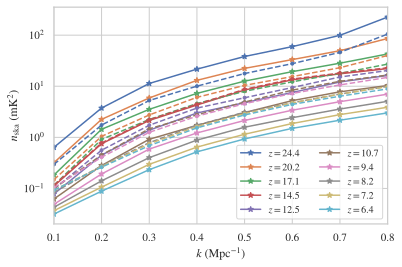

In [14]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)

optimTimes = np.loadtxt("./TimeData/optimizedTimeTvir.txt", dtype=np.float32)[:, 0].reshape(10, 1)
instNoiseOptim = instNoise*1000./optimTimes

fig, ax = plt.subplots()
k_vals = np.linspace(0.1, 0.8, 8)
for i in range(len(reds)):
    ax.plot(k_vals, instNoise[i], "*-", label=r"$z = %.1f$"%reds[i])
    ax.set_yscale("log")
    ax.set_xlim(k_vals[0], k_vals[-1])
    ax.legend(ncol=2, fontsize=10)
    ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    ax.set_ylabel(r"$n_{\rm ska}$ (mK$^2$)")

for i in range(len(reds)):
    ax.plot(k_vals, instNoiseOptim[i], ".--", label=r"$z = %.1f$"%reds[i])

In [15]:
# Instrumental noise level from SKA low: sim using ps_eor
# change-1 for instNoiseOptim
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        sv = out['pk_sv_z%.1f'%reds[i]]
        
        # Total noise including the intrumental noise and sample variance
        total_noise_val = np.sqrt(instNoiseOptim[i]**2. + sv**2.)
        n = np.float32(np.random.randn(*total_noise_val.shape))*total_noise_val
        
        out['pk_z%.1f'%reds[i]] = mu + n
    return out

In [16]:
zs = sl.ZarrStore("/local/tmp/s21cm_Astro_6.zarr")
data_loader_train = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[0, 16_000], hook=noise)
data_loader_val = zs.get_dataloader(num_workers=12, batch_size=64, idx_range=[16_000, 20_000], hook=noise)

In [17]:
trainer_1D = sl.SwyftTrainer(accelerator='gpu', gpus=1, max_epochs=100,
                             **sl.tensorboard_config(name = 'optimizedTvir', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [18]:
import torch.nn as nn    

class Network_1D(sl.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-4)
        self.n_features = 32
        self.l = torch.nn.Linear(80, 32, device='cuda')
        
        self.classifier = sl.RatioEstimatorMLP1d(self.n_features, 1, hidden_features=256,
                                                 num_blocks=2, dropout=0.1)
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds], axis=1)
        x = self.l(x)
        z = B['z'][:, 1].reshape(B['z'][:, 1].shape[0], 1)
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [19]:
network_1D = Network_1D()

In [20]:
%%time
trainer_1D.fit(network_1D, data_loader_train, data_loader_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type                | Params
---------------------------------------------------
0 | l          | Linear              | 2.6 K 
1 | classifier | RatioEstimatorMLP1d | 274 K 
---------------------------------------------------
276 K     Trainable params
0         Non-trainable params
276 K     Total params
1.107     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/p303146/.envs/lightning/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 1min 18s, sys: 28.2 s, total: 1min 46s
Wall time: 1min 57s


In [21]:
with open(obsPath, 'rb') as f:
    obs0 = pickle.load(f)
    
for k in obs0.keys():
    obs0[k] = obs0[k].numpy()

obs0 = noise(obs0)
pd_1D = trainer_1D.infer(network_1D, data_loader_train,
                         conditions={'pk_z%.1f'%zi: torch.tensor(obs0['pk_z%.1f'%zi],
                                                                 dtype=torch.float32) for zi in reds})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 250it [00:00, ?it/s]

In [11]:
post_samples_1D = pd_1D.sample(1_000_000)
samples_1D = post_samples_1D['z'].numpy()

In [22]:
post_samples_1D_optim = pd_1D.sample(1_000_000)
samples_1D_optim = post_samples_1D_optim['z'].numpy()

/data/p303146/.envs/lightning/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/data/p303146/.envs/lightning/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


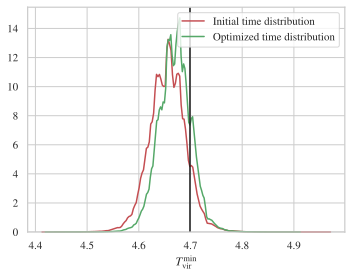

In [24]:
fig, axes = plt.subplots(figsize=(5, 4))
cn = 0
sns.distplot(ax=axes, a=samples_1D[:, cn], hist=False, kde=True,
             bins=25, hist_kws={'edgecolor':'black'}, axlabel=None, color="r",
            label="Initial time distribution")
sns.distplot(ax=axes, a=samples_1D_optim[:, cn], hist=False, kde=True,
             bins=25, hist_kws={'edgecolor':'black'}, axlabel=None, color="g",
            label="Optimized time distribution")
axes.axvline(vtrue[1], color='k')
axes.set_xlabel("%s"%labels[1])
axes.set_ylabel("")
cn += 1
plt.legend()
plt.tight_layout()
#plt.savefig("./Figures/optimizedPost_Rmfp.pdf", bbox_inches="tight")
plt.show()